<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-subgraph" data-toc-modified-id="Get-subgraph-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get subgraph</a></span></li></ul></div>

In [1]:
import sys
sys.path += ['..', './qaoa']
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import qtree

import utils_qaoa as qu
import utils

%load_ext autoreload
%autoreload 2

ModuleNotFoundError("No module named 'tensorflow'")


In [19]:
G = qu.get_test_graph(1000, type='randomreg', degree=5)
#nx.draw(G, with_labels=True)

## Get subgraph

In [20]:
def nodes_at_distance(G, nodes, dist):
    nodes = list(nodes)
    for d in range(dist):
        range_d_nodes = []
        for n in nodes:
            neigh = list(G[n].keys())
            range_d_nodes += neigh
        nodes += range_d_nodes
    return set(nodes)

def get_edge_subgraph(G, edge, dist):
    nodes = nodes_at_distance(G, edge, dist)
    return G.subgraph(set(nodes))
            
    
edge = list(G.edges)[0]
print('Using edge', edge)
nodes = nodes_at_distance(G, edge, 2)
cmap = ['red' if n in nodes else 'blue' for n in G]

#nx.draw(G, node_color=cmap, with_labels=True)


Using edge (0, 1)


In [21]:
def get_energy_contrib_expr(G, edge, p):
    subgraph = G.subgraph(nodes_at_distance(G, edge, p))
    beta, gamma = [np.pi/3]*p, [np.pi/2]*p
    G = subgraph
    N = G.number_of_nodes()
    mapping = {n:i for n, i in zip(G.nodes, range(N))}
    G = nx.relabel_nodes(G, mapping)
    qc = []
    qc += qu.get_qaoa_circuit(G, beta, gamma)
    qc += [[qtree.operators.cZ(*edge)]]
    qc += qu.get_qaoa_circuit(G, beta, gamma)
    
    buck, _,_,_ = qtree.optimizer.circ2buckets(N, qc)
    graph = qtree.graph_model.buckets2graph(buck)
    return graph, N
    

graph, N = get_energy_contrib_expr(G, edge, 4)
n_nodes = graph.number_of_nodes()
print(f'Use {N} qubits, {n_nodes} nodes')

Use 674 qubits, 25082 nodes


/usr/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


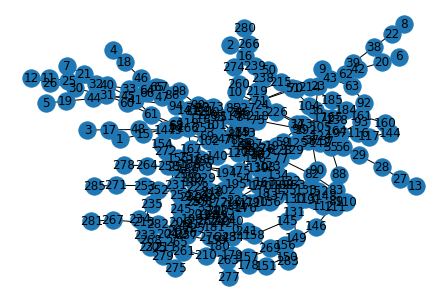

In [103]:
nx.draw(graph, with_labels=True)

In [22]:
peo, nghs = utils.get_locale_peo(graph, utils.n_neighbors)


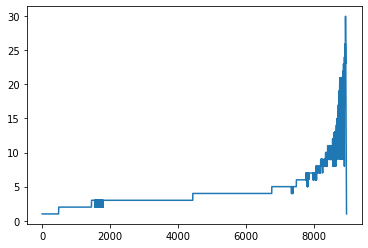

In [15]:
plt.plot(nghs)

In [106]:
mems, flops = qu.cost_graph_peo(graph, peo)

100%|██████████| 286/286 [00:01<00:00, 220.70it/s]


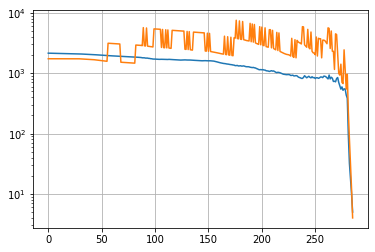

In [107]:
plt.plot(mems)
plt.plot(flops)
plt.yscale('log')
plt.grid()

In [108]:
cone_cost = max(mems), sum(flops)
cones = G.number_of_edges()
tot_cost = max(mems), sum(flops)*cones

print(f'One lightcone {cone_cost[0]} Mem {cone_cost[1]:2.2e} flop')
print(f'All {cones} lightcones {tot_cost[0]} Mem {tot_cost[1]:2.2e} flop')

One lightcone 2142 Mem 8.36e+05 flop
All 93750 lightcones 2142 Mem 7.84e+10 flop
